# Assignment 4

#### 1. Generación de Datos

1. Importación de bibliotecas:

In [276]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score
from keras.api import layers, models
from keras.api.callbacks import EarlyStopping
from keras.api.optimizers import Adam


2. Crear 3 bolas en un plano (R2) y girarlas en R10:

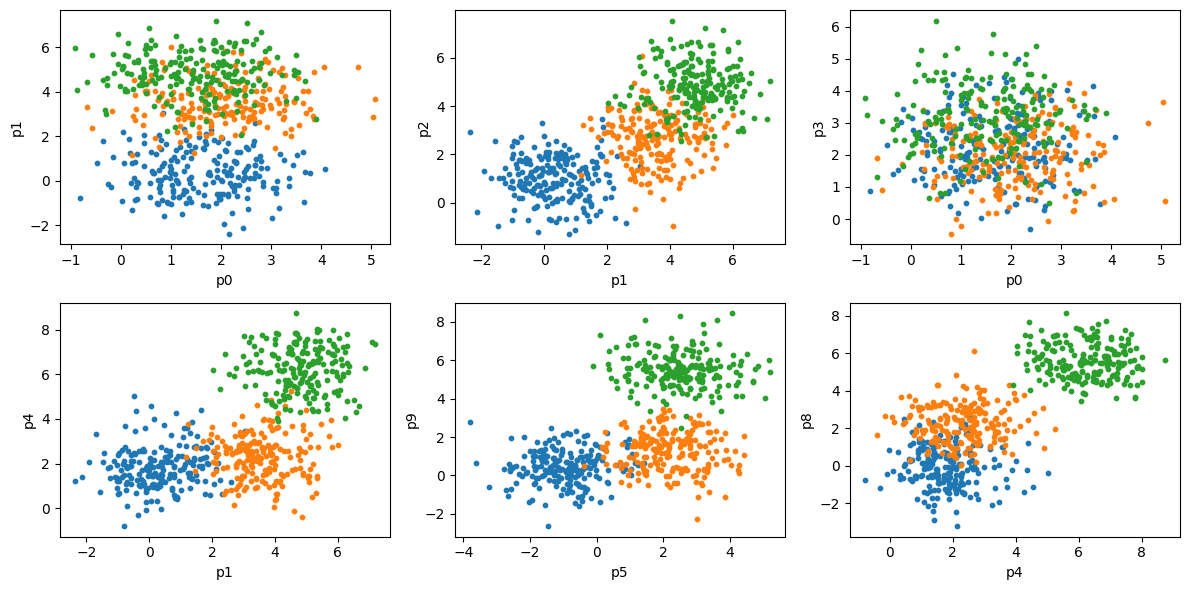

In [223]:
def generate_spheres(samples_per_class, dim=10):
    np.random.seed(0)
    centers = [np.zeros((1, 10)), np.zeros((1, 10)), np.zeros((1, 10))]
    centers[0][:] += np.random.normal(size=(1, 10)) + 0
    centers[1][:] += np.random.normal(size=(1, 10)) + 2
    centers[2][:] += np.random.normal(size=(1, 10)) + 4
    data, labels = [], []
    for idx, center in enumerate(centers):
        sphere_10d = np.zeros((samples_per_class, dim))
        sphere_10d[:, :] = np.random.normal(size=(samples_per_class, 10)) + center
        data.append(sphere_10d)
        labels.extend([idx] * samples_per_class)
    return np.vstack(data), np.array(labels)

X, y = generate_spheres(samples_per_class=200)

# Mostrar los datos en 2D con algunas proyecciones
projections = [(0, 1), (1, 2), (0, 3), (1, 4), (5, 9), (4, 8)]
plt.figure(figsize=(12, 6))
for i, (p0, p1) in enumerate(projections):
    plt.subplot(2, 3, i + 1)
    plt.scatter(X[y == 0, p0], X[y == 0, p1], label='0', s=10)
    plt.scatter(X[y == 1, p0], X[y == 1, p1], label='1', s=10)
    plt.scatter(X[y == 2, p0], X[y == 2, p1], label='2', s=10)
    plt.xlabel(f'p{p0}')
    plt.ylabel(f'p{p1}')
plt.tight_layout()
plt.show()


#### 2. Proyección en R2

2.1. Sammon:

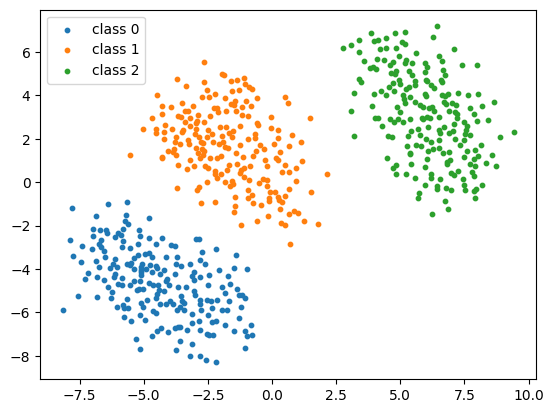

In [280]:
sammon = MDS(n_components=2, metric=True)
X_sammon = sammon.fit_transform(X)

plt.scatter(X_sammon[y == 0, 0], X_sammon[y == 0, 1], label='class 0', s=10)
plt.scatter(X_sammon[y == 1, 0], X_sammon[y == 1, 1], label='class 1', s=10)
plt.scatter(X_sammon[y == 2, 0], X_sammon[y == 2, 1], label='class 2', s=10)
plt.legend()
plt.show()


2.2. PCA:

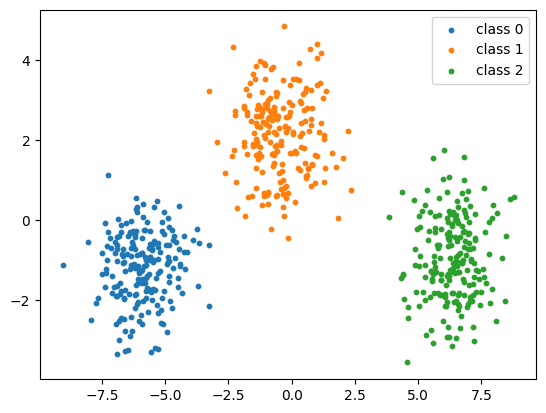

In [227]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='class 0', s=10)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='class 1', s=10)
plt.scatter(X_pca[y == 2, 0], X_pca[y == 2, 1], label='class 2', s=10)
plt.legend()
plt.show()


2.3. LDA:

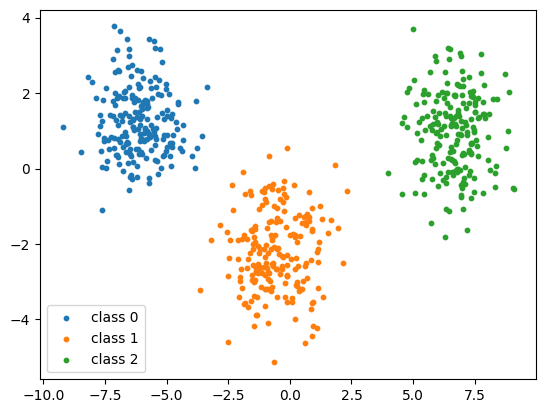

In [228]:
lda = LDA(n_components=2)
X_lda = lda.fit_transform(X, y)

plt.scatter(X_lda[y == 0, 0], X_lda[y == 0, 1], label='class 0', s=10)
plt.scatter(X_lda[y == 1, 0], X_lda[y == 1, 1], label='class 1', s=10)
plt.scatter(X_lda[y == 2, 0], X_lda[y == 2, 1], label='class 2', s=10)
plt.legend()
plt.show()


2.4. t-SNE:

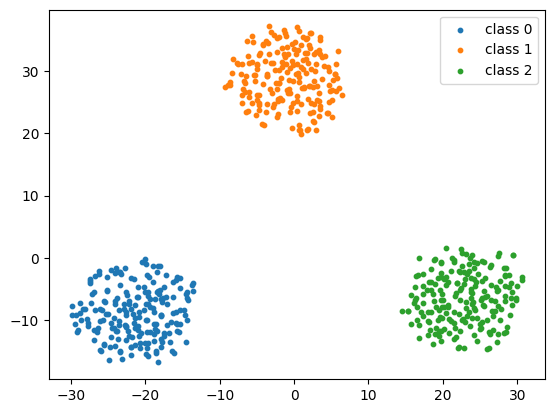

In [229]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.scatter(X_tsne[y == 0, 0], X_tsne[y == 0, 1], label='class 0', s=10)
plt.scatter(X_tsne[y == 1, 0], X_tsne[y == 1, 1], label='class 1', s=10)
plt.scatter(X_tsne[y == 2, 0], X_tsne[y == 2, 1], label='class 2', s=10)
plt.legend()
plt.show()


#### 3. Red Neuronal Encoder-Decoder

Arquitectura del Encoder-Decoder:

In [338]:
# Definir la arquitectura del Encoder-Decoder
def build_encoder_decoder(input_dim=10, encoded_dim=2):
    input_layer = layers.Input(shape=(input_dim,), name='Input')
    
    # Encoder
    encoded = layers.Dense(8, activation='relu', name='Dense8_encoder')(input_layer)
    encoded = layers.Dense(6, activation='relu', name='Dense6_encoder')(encoded)
    encoded = layers.Dense(4, activation='relu', name='Dense4_encoder')(encoded)
    encoded = layers.Dense(encoded_dim, activation='linear', name=f'Dense{encoded_dim}')(encoded)

    # Decoder
    decoded = layers.Dense(4, activation='relu', name='Dense4_decoder')(encoded)
    decoded = layers.Dense(6, activation='relu', name='Dense6_decoder')(decoded)
    decoded = layers.Dense(8, activation='relu', name='Dense8_decoder')(decoded)
    decoded = layers.Dense(input_dim, activation='linear', name='Output')(decoded)
    
    # Modelo completo
    autoencoder = models.Model(input_layer, decoded, name='Autoencoder')
    
    # Encoder separado para reutilización
    encoder = models.Model(input_layer, encoded, name='Encoder')
    
    return autoencoder, encoder

# Dividir los datos en entrenamiento, validación y prueba
xtrn, xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
xtrn, xval, ytrn, yval = train_test_split(xtrn, ytrn, test_size=0.1, stratify=ytrn, random_state=42)

print(xtrn.shape, xval.shape, xtst.shape, ytrn.shape, yval.shape, ytst.shape)

# Construir los modelos
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=1e-2)
optimizer = Adam(learning_rate=0.01)

autoencoder, encoder = build_encoder_decoder()
autoencoder.compile(optimizer=optimizer, loss='mse')

autoencoder.summary()
encoder.summary()


(432, 10) (48, 10) (120, 10) (432,) (48,) (120,)


Model: "Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense8_encoder (Dense)          │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense6_encoder (Dense)          │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense4_encoder (Dense)          │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense4_decoder (Dense)          │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense6_decoder (Dense)          │ (None, 6)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense8_decoder (Dense)          │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368 (1.44 KB)

 Trainable params: 368 (1.44 KB)

 Non-trainable params: 0 (0.00 B)

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense8_encoder (Dense)          │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense6_encoder (Dense)          │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense4_encoder (Dense)          │ (None, 4)              │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense2 (Dense)                  │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 180 (720.00 B)

 Trainable params: 180 (720.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del Encoder-Decoder:

In [339]:
# Entrenamiento del autoencoder
autoencoder_history = autoencoder.fit(
    xtrn, xtrn, 
    epochs=150, 
    batch_size=xtrn.shape[0]//4, 
    validation_data=(xval, xval), 
    callbacks=[early_stopping]
)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - loss: 15.8278 - val_loss: 10.3703
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 10.3111 - val_loss: 9.3530
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 9.0645 - val_loss: 9.1885
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 8.7349 - val_loss: 8.8731
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - loss: 9.0044 - val_loss: 8.4127
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 7.9243 - val_loss: 7.6438
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 7.6246 - val_loss: 6.4557
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 6.3900 - val_loss: 5.0504
Epoch 9/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 4.9025 - val_loss: 3.9951
Epoch 10/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 4.0319 - val_loss: 2.9228
Epoch 11/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.9799 - val_loss: 2.1291
Epoch 12/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 2.2603 - v

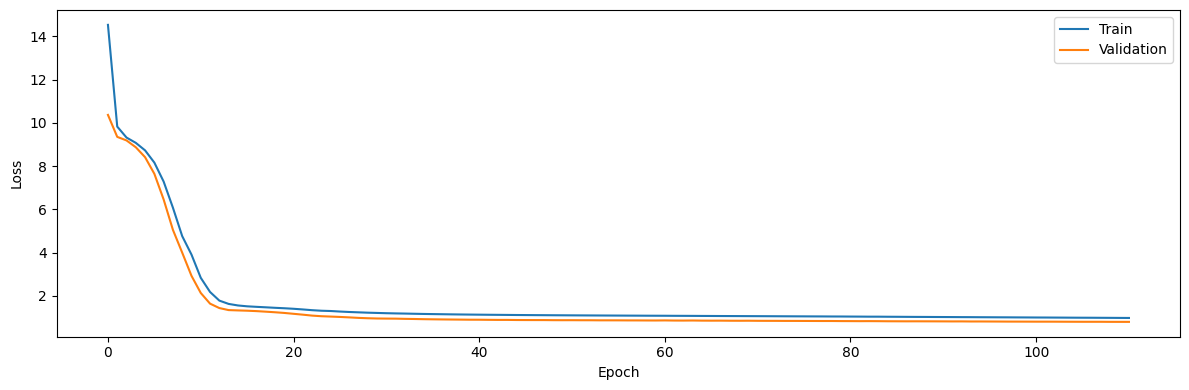

In [340]:
# Visualizar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.plot(autoencoder_history.history['loss'], label='Train')
plt.plot(autoencoder_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step 
(120, 10) (120, 2)


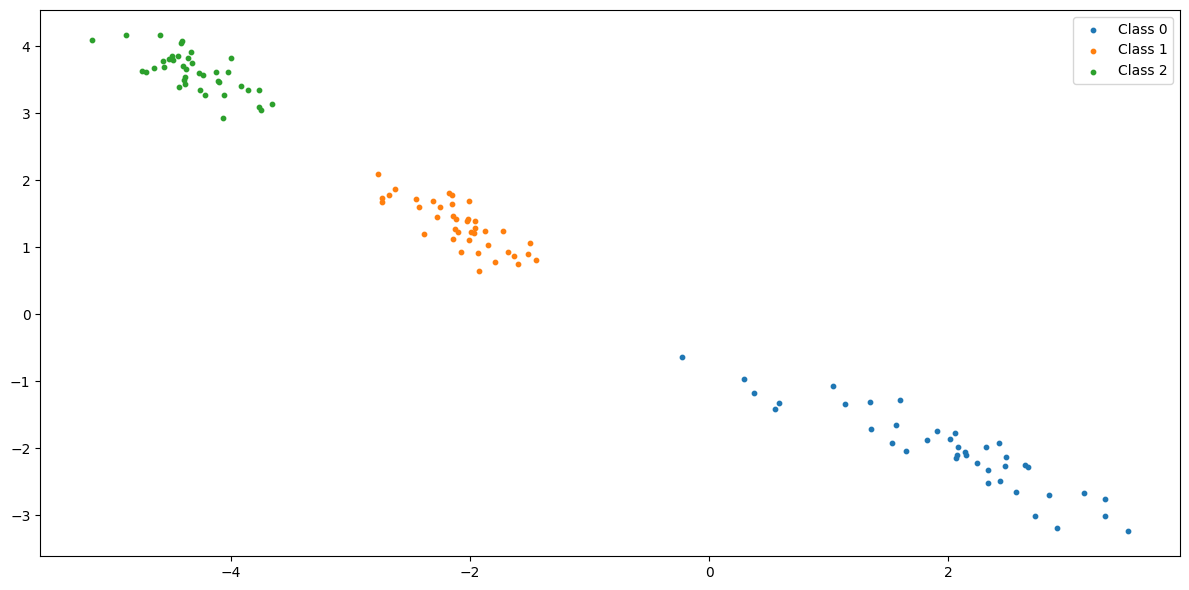

In [341]:
# Visualizar la reconstrucción
xtrn_encoded = encoder.predict(xtrn)
xval_encoded = encoder.predict(xval)
xtst_encoded = encoder.predict(xtst)

print(xtst.shape, xtst_encoded.shape)

plt.figure(figsize=(12, 6))
plt.scatter(xtst_encoded[ytst == 0, 0], xtst_encoded[ytst == 0, 1], label='Class 0', s=10)
plt.scatter(xtst_encoded[ytst == 1, 0], xtst_encoded[ytst == 1, 1], label='Class 1', s=10)
plt.scatter(xtst_encoded[ytst == 2, 0], xtst_encoded[ytst == 2, 1], label='Class 2', s=10)
plt.legend()
plt.tight_layout()
plt.show()


#### 4: Clasificador con Encoder Congelado

In [ ]:
# Crear el modelo secuencial para clasificación
classification_model = models.Sequential([
    layers.Input(shape=(2,), name='Input'),
    layers.Dense(3, activation='softmax', name='Classifier_Output')  # Capa de clasificación
])

# Compilar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=1e-2)
optimizer = Adam(learning_rate=0.01)
classification_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

classification_model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Classifier_Output (Dense)       │ (None, 3)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamiento del clasificador:

In [343]:
# Entrenar el clasificador con el encoder congelado
classifier_history = classification_model.fit(
    xtrn_encoded, ytrn, 
    epochs=150, 
    batch_size=xtrn_encoded.shape[0]//4, 
    validation_data=(xval_encoded, yval), 
    callbacks=[early_stopping]
)


Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.3318 - loss: 1.6419 - val_accuracy: 0.3333 - val_loss: 1.5137
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3611 - loss: 1.4198 - val_accuracy: 0.3333 - val_loss: 1.3452
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3843 - loss: 1.2540 - val_accuracy: 0.3333 - val_loss: 1.1884
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3833 - loss: 1.1457 - val_accuracy: 0.3333 - val_loss: 1.0437
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4086 - loss: 1.0169 - val_accuracy: 0.4583 - val_loss: 0.9159
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4895 - loss: 0.8720 - val_accuracy: 0.6667 - val_loss: 0.8084
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6441 - loss: 0.7863 - val_accuracy: 0.6667 - val_loss: 0.7217
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6586 - loss: 0.7188 - val_accuracy: 0.6667 - val_loss

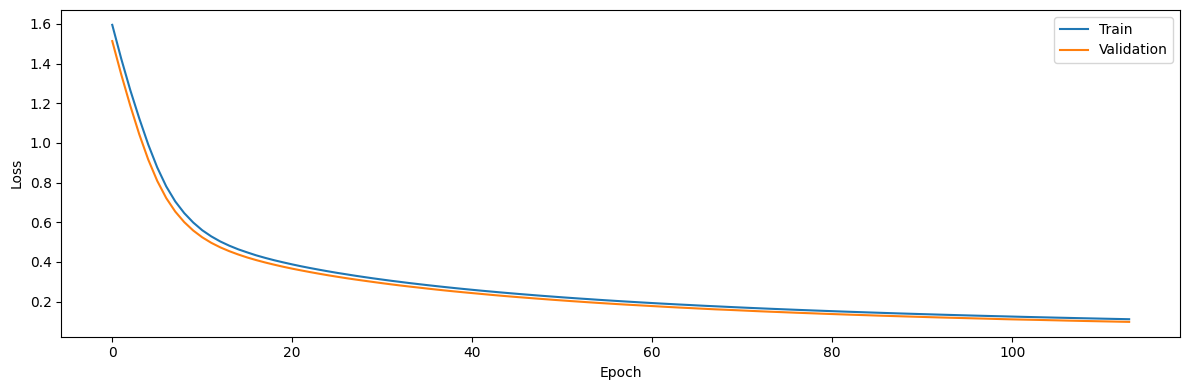

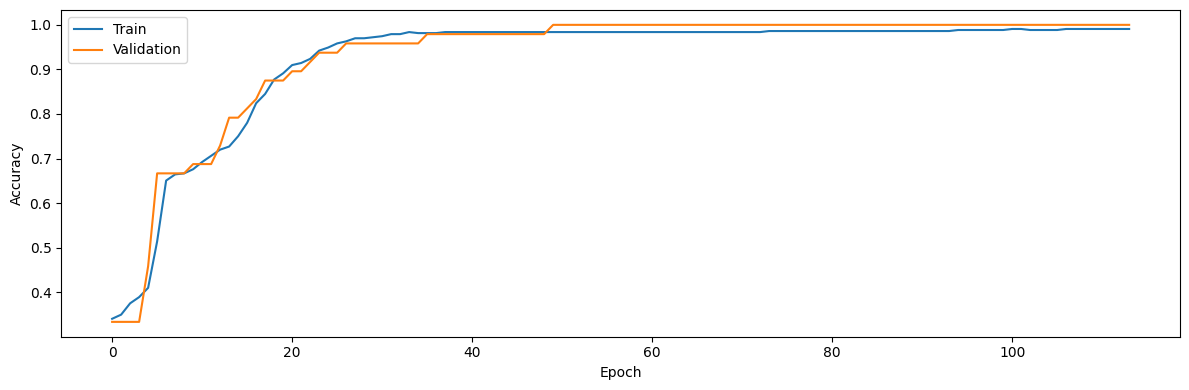

In [344]:
# Visualizar la pérdida y la precisión
plt.figure(figsize=(12, 4))
plt.plot(classifier_history.history['loss'], label='Train')
plt.plot(classifier_history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(classifier_history.history['accuracy'], label='Train')
plt.plot(classifier_history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [345]:
# Evaluar el modelo
ypred = classification_model.predict(xtst_encoded)
ypred = np.argmax(ypred, axis=1)

accuracy = accuracy_score(ytst, ypred)
print(f'Accuracy: {accuracy:.2f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Accuracy: 1.00


258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


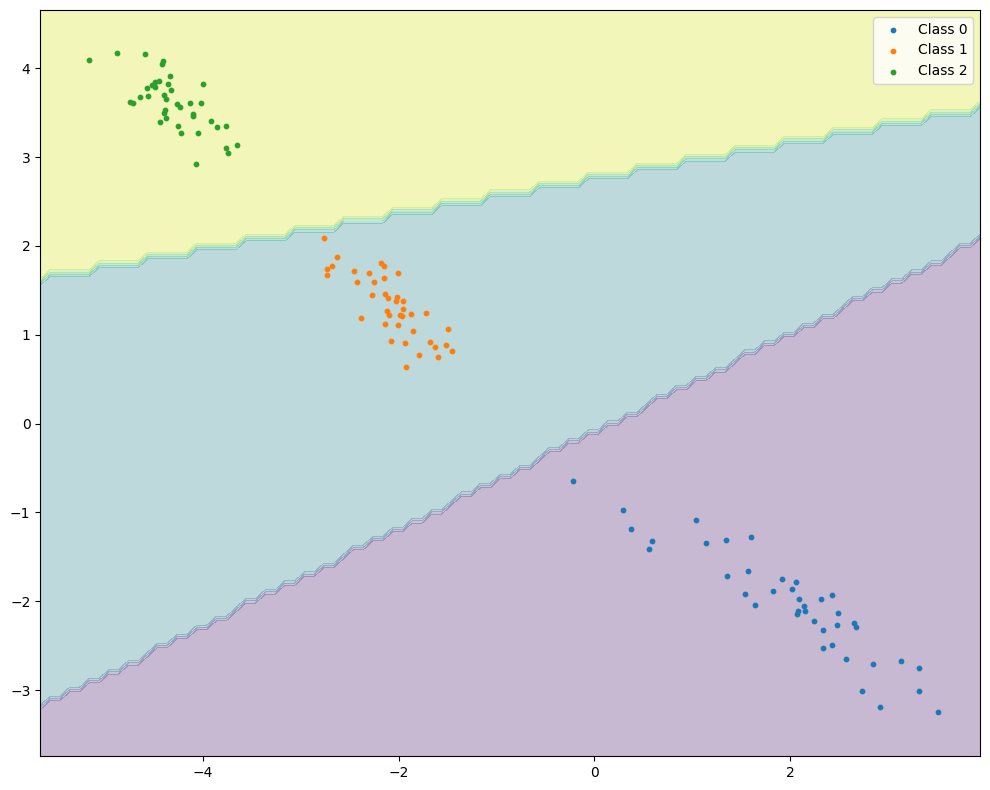

In [348]:
# Decision boundaries
x_min, x_max = xtst_encoded[:, 0].min() - 0.5, xtst_encoded[:, 0].max() + 0.5
y_min, y_max = xtst_encoded[:, 1].min() - 0.5, xtst_encoded[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
grid = np.c_[xx.ravel(), yy.ravel()]

Z = classification_model.predict(grid)
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(xtst_encoded[ytst == 0, 0], xtst_encoded[ytst == 0, 1], label='Class 0', s=10)
plt.scatter(xtst_encoded[ytst == 1, 0], xtst_encoded[ytst == 1, 1], label='Class 1', s=10)
plt.scatter(xtst_encoded[ytst == 2, 0], xtst_encoded[ytst == 2, 1], label='Class 2', s=10)
plt.legend()
plt.tight_layout()
plt.show()
